In [101]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [102]:
df = pd.read_csv("./crop_yield.csv").drop_duplicates()
str_cols = df.select_dtypes(include='object').columns
df[str_cols] = df[str_cols].apply(lambda col: col.str.strip())

df["Crop_Year"] = df["Crop_Year"].astype("category")
print(df.isnull().sum())
print(df.shape)
print(df.dtypes)

Crop               0
Crop_Year          0
Season             0
State              0
Area               0
Production         0
Annual_Rainfall    0
Fertilizer         0
Pesticide          0
Yield              0
dtype: int64
(19689, 10)
Crop                 object
Crop_Year          category
Season               object
State                object
Area                float64
Production            int64
Annual_Rainfall     float64
Fertilizer          float64
Pesticide           float64
Yield               float64
dtype: object


Columns Description:  
Crop: The name of the crop cultivated.  
Crop_Year: The year in which the crop was grown.  
Season: The specific cropping season (e.g., Kharif, Rabi, Whole Year).  
State: The Indian state where the crop was cultivated.  
Area: The total land area (in hectares) under cultivation for the specific crop.  
Production: The quantity of crop production (in metric tons).  
Annual_Rainfall: The annual rainfall received in the crop-growing region (in mm).  
Fertilizer: The total amount of fertilizer used for the crop (in kilograms).  
Pesticide: The total amount of pesticide used for the crop (in kilograms).  
Yield: The calculated crop yield (production per unit area).  

In [103]:
print(df.iloc[13313])

Crop                 Ginger
Crop_Year              2013
Season               Kharif
State               Manipur
Area                 2850.0
Production            34200
Annual_Rainfall      1428.8
Fertilizer         411796.5
Pesticide             769.5
Yield                  12.0
Name: 13313, dtype: object


In [104]:
df.describe()

,Area,Production,Annual_Rainfall,Fertilizer,Pesticide,Yield
count,1.968900e+04,1.968900e+04,19689.000000,1.968900e+04,1.968900e+04,19689.000000
mean,1.799266e+05,1.643594e+07,1437.755177,2.410331e+07,4.884835e+04,79.954009
std,7.328287e+05,2.630568e+08,816.909589,9.494600e+07,2.132874e+05,878.306193
min,5.000000e-01,0.000000e+00,301.300000,5.417000e+01,9.000000e-02,0.000000
25%,1.390000e+03,1.393000e+03,940.700000,1.880146e+05,3.567000e+02,0.600000
50%,9.317000e+03,1.380400e+04,1247.600000,1.234957e+06,2.421900e+03,1.030000
75%,7.511200e+04,1.227180e+05,1643.700000,1.000385e+07,2.004170e+04,2.388889
max,5.080810e+07,6.326000e+09,6552.700000,4.835407e+09,1.575051e+07,21105.000000


In [105]:
df = df[df['Yield']>0]
output_label = 'log_yield'
df[output_label] = df['Yield'].apply(lambda x:np.log(x))

In [106]:
epsilon = 1e-6  

# divide fertilizer and pesticide by area (in kg/hectare)
for col in ['Fertilizer', 'Pesticide']:
    df[f'log_{col}_per_area'] = (df[col]/df['Area']).apply(lambda x:np.log(x+epsilon))
df['log_Annual_Rainfall'] = df['Annual_Rainfall'].apply(lambda x:np.log(x+epsilon))

In [107]:

# drop unused columns
dropCols = ['Production', 'Yield', 'Fertilizer', 'Pesticide', 'Area', 'Annual_Rainfall']
df = df.drop(dropCols, axis=1)
print(df.shape)
df.sample(5).T

(19577, 8)


,3562,9761,12575,19680,4885
Crop,Wheat,Potato,Potato,Wheat,Gram
Crop_Year,2011,2006,2012,2018,2016
Season,Rabi,Whole Year,Rabi,Summer,Rabi
State,Meghalaya,Gujarat,Chhattisgarh,Odisha,Meghalaya
log_yield,0.29267,3.018338,2.00371,0.60158,0.075107
log_Fertilizer_per_area,5.121103,4.849762,5.015954,5.08883,5.032071
log_Pesticide_per_area,-1.10866,-1.514123,-1.17118,-1.049819,-1.049819
log_Annual_Rainfall,8.314613,6.962433,7.220228,7.399948,8.252472


/tmp/ipykernel_34796/3952823627.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



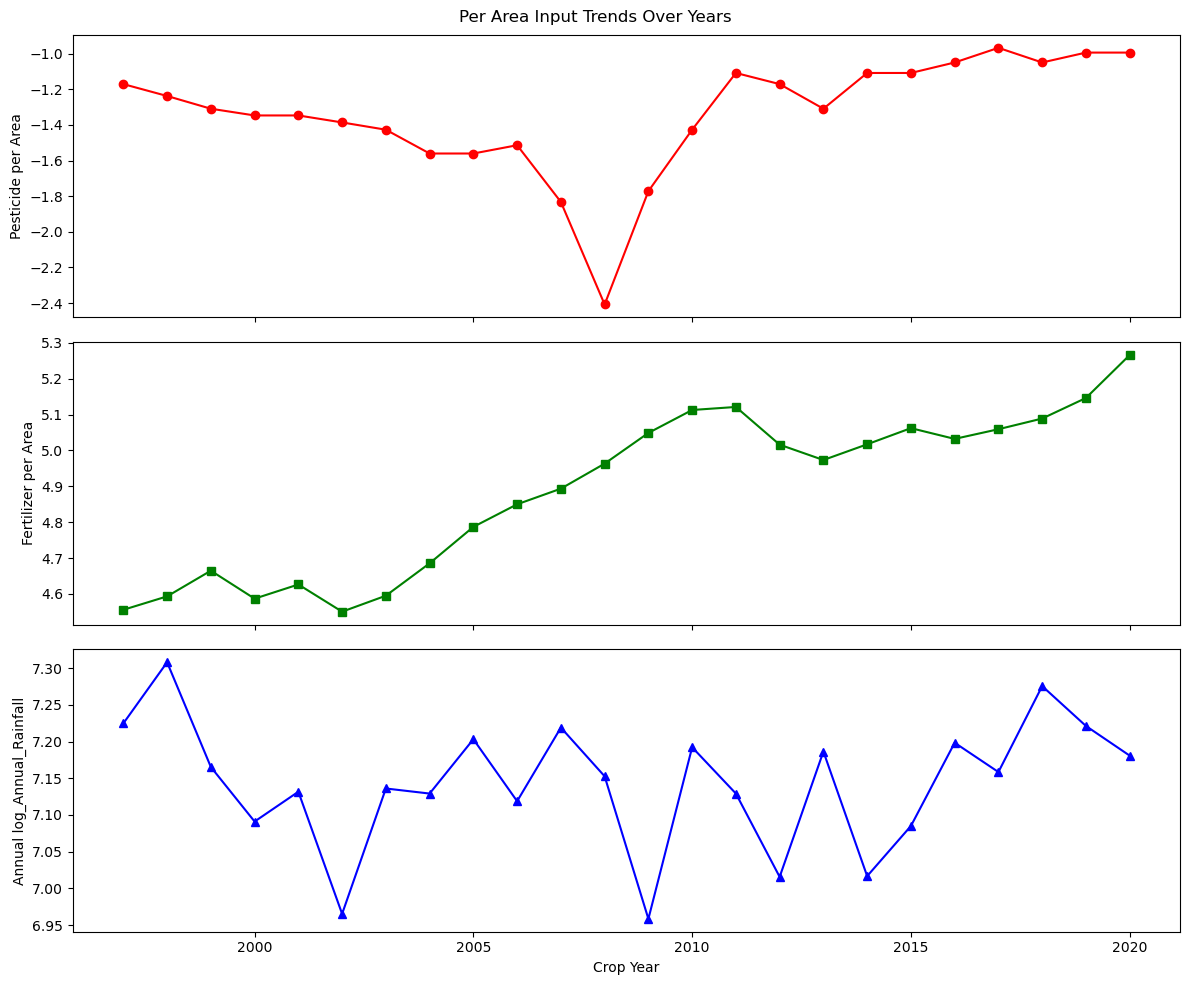

In [109]:
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

grouped = df.groupby('Crop_Year')[['log_Pesticide_per_area', 'log_Fertilizer_per_area', 'log_Annual_Rainfall']].mean()

axes[0].plot(grouped.index, grouped['log_Pesticide_per_area'], marker='o', color='r')
axes[0].set_ylabel('Pesticide per Area')

axes[1].plot(grouped.index, grouped['log_Fertilizer_per_area'], marker='s', color='g')
axes[1].set_ylabel('Fertilizer per Area')

axes[2].plot(grouped.index, grouped['log_Annual_Rainfall'], marker='^', color='b')
axes[2].set_ylabel('Annual log_Annual_Rainfall')
axes[2].set_xlabel('Crop Year')

fig.suptitle('Per Area Input Trends Over Years')
plt.tight_layout()
plt.show()

In [110]:
cat_cols_idx=[0,1,2,3]
cat_col_names = df.columns[cat_cols_idx]

print(cat_col_names)

Index(['Crop', 'Crop_Year', 'Season', 'State'], dtype='object')


In [111]:
y = df[output_label].values.reshape(-1,) # output feature
X = df.drop([output_label], axis=1) # inputs

## Spliting Data

In [112]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
import numpy as np

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Print the shapes of training and test sets
print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)
print("Training target shape:", y_train.shape)

Training data shape: (15661, 7)
Test data shape: (3916, 7)
Training target shape: (15661,)


In [113]:
print(df.dtypes)

Crop                         object
Crop_Year                  category
Season                       object
State                        object
log_yield                   float64
log_Fertilizer_per_area     float64
log_Pesticide_per_area      float64
log_Annual_Rainfall         float64
dtype: object


## Model Training using Optuna for hyper parameter tuning

In [114]:
import optuna
from sklearn.model_selection import cross_val_score

def objective(trial):
    params = {
                "iterations": 1200,
                "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
                "depth": trial.suggest_int("depth", 4, 10),
                "subsample": trial.suggest_float("subsample", 0.05, 1.0),
                "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
                "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
                "boosting_type": "Ordered",
            }


    model = CatBoostRegressor(**params, cat_features=cat_cols_idx, silent=True)
    score=cross_val_score(model, X_train, y_train, cv=3, scoring="r2").mean()
    return score

study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=20)

print('Best hyperparameters:', study.best_params)
print(f'Best R2:, {study.best_value:.4f}')


[I 2025-08-21 13:05:36,788] A new study created in memory with name: no-name-da709b5c-c82c-45f2-b364-3e43dbd339d7
[I 2025-08-21 13:05:56,081] Trial 0 finished with value: 0.9034751587845739 and parameters: {'learning_rate': 0.04150055160778599, 'depth': 6, 'subsample': 0.8324736997025207, 'colsample_bylevel': 0.6168941622726981, 'min_data_in_leaf': 81}. Best is trial 0 with value: 0.9034751587845739.
[I 2025-08-21 13:06:05,532] Trial 1 finished with value: 0.7597322729929639 and parameters: {'learning_rate': 0.0014881196354355202, 'depth': 5, 'subsample': 0.13431780825249529, 'colsample_bylevel': 0.6115754109821008, 'min_data_in_leaf': 2}. Best is trial 0 with value: 0.9034751587845739.
[I 2025-08-21 13:06:14,594] Trial 2 finished with value: 0.8192595932188521 and parameters: {'learning_rate': 0.006113167274177514, 'depth': 8, 'subsample': 0.06884652112713413, 'colsample_bylevel': 0.18397282393134495, 'min_data_in_leaf': 28}. Best is trial 0 with value: 0.9034751587845739.
[I 2025-08-

Best hyperparameters: {'learning_rate': 0.09835094155253181, 'depth': 10, 'subsample': 0.4734250333151104, 'colsample_bylevel': 0.9987923563649226, 'min_data_in_leaf': 100}
Best R2:, 0.9284


In [115]:
from optuna.visualization import plot_optimization_history, plot_parallel_coordinate, plot_param_importances

plot_optimization_history(study).show()

In [116]:
plot_parallel_coordinate(study).show()

In [117]:
plot_param_importances(study).show()

### Model for best parameters

In [118]:
best_params = study.best_params
model = CatBoostRegressor(boosting_type='Ordered', **best_params, cat_features=cat_cols_idx, silent=True)
model.fit(X_train, y_train)
model.save_model("model.cbm")
y_pred_log = model.predict(X_test)

## Prediciton Metrices

In [119]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score, median_absolute_error

# Undo the log transformation
y_pred_orig = np.exp(y_pred_log)
y_test_orig = np.exp(y_test)

mae = mean_absolute_error(y_test_orig, y_pred_orig)
medae = median_absolute_error(y_test_orig, y_pred_orig)
mape = mean_absolute_percentage_error(y_test_orig, y_pred_orig)
r2 = r2_score(y_test_orig, y_pred_orig)

# Adjusted R²
n = len(y_test)
p = X_test.shape[1]
adjusted_r2 = 1 - ((1 - r2) * (n - 1)) / (n - p - 1)

print("Evaluation Metrics (Original Scale):")
print(f"Mean Absolute Error : {mae:.4f}")
print(f"Median Absolute Error : {medae:.4f}")
print(f"Median Absolute Percentage Error : {mape:.4f}")
print(f"R-squared (R²): {r2:.4f}")
print(f"Adjusted R-squared (adj R²): {adjusted_r2:.4f}")


Evaluation Metrics (Original Scale):
Mean Absolute Error : 14.1697
Median Absolute Error : 0.1646
Median Absolute Percentage Error : 0.2544
R-squared (R²): 0.9634
Adjusted R-squared (adj R²): 0.9633


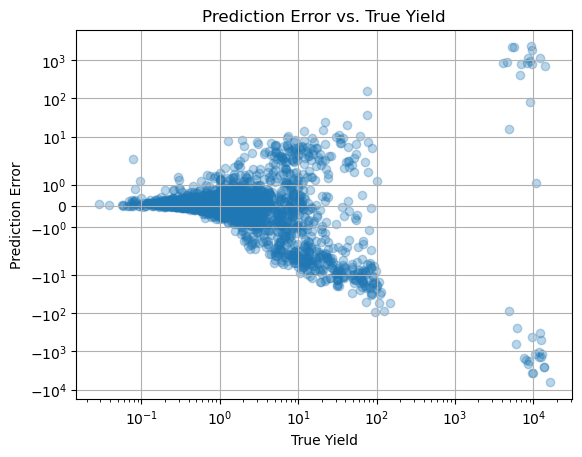

In [120]:
import matplotlib.pyplot as plt

errors = y_pred_orig - y_test_orig
plt.scatter(y_test_orig, errors, alpha=0.3)
plt.xlabel("True Yield")
plt.ylabel("Prediction Error")
plt.title("Prediction Error vs. True Yield")
plt.yscale("symlog")
plt.xscale("log")
plt.grid(True)
plt.show()


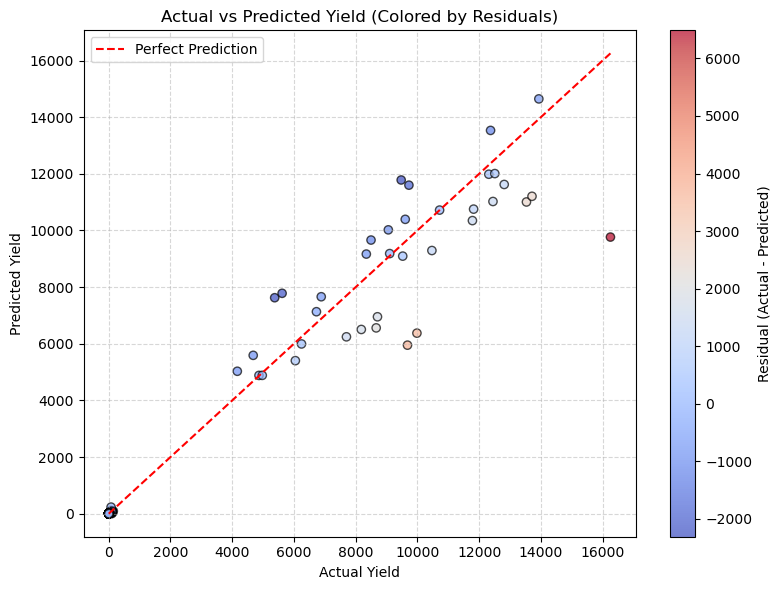

In [121]:
import matplotlib.pyplot as plt
import numpy as np

residuals = y_test_orig - y_pred_orig

plt.figure(figsize=(8, 6))
scatter = plt.scatter(y_test_orig, y_pred_orig, c=residuals, cmap='coolwarm', edgecolors='k', alpha=0.7)
plt.plot([min(y_test_orig), max(y_test_orig)],[min(y_test_orig), max(y_test_orig)], 'r--', label='Perfect Prediction')

plt.xlabel('Actual Yield')
plt.ylabel('Predicted Yield')
plt.title('Actual vs Predicted Yield (Colored by Residuals)')
plt.colorbar(scatter, label='Residual (Actual - Predicted)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## Testing Predicitons

In [122]:
def predict_new_data(features):
    # Convert the input dictionary to a pandas DataFrame (match the structure of X)
    input_data = pd.DataFrame(features)  # Single row DataFrame
    
    # Make prediction using the trained model
    prediction = model.predict(input_data)
    
    return prediction

In [175]:
random_idx = np.random.randint(0, len(X_test))

X_sample = X_test.iloc[[random_idx]]
y_actual_log = y_test[random_idx]
y_actual = np.exp(y_actual_log)


str_cols = X_sample.select_dtypes(include='object').columns
X_sample.loc[:, str_cols] = X_sample[str_cols].apply(lambda col: col.str.strip())


y_pred_log = model.predict(X_sample)
y_pred = np.exp(y_pred_log)

print(f"Actual Yield: {y_actual:.8f}")
print(f"Predicted Yield: {y_pred[0]:.2f}")
print(f"Absolute Error: {abs(y_pred[0] - y_actual):.2f}")

Actual Yield: 8.33000000
Predicted Yield: 9.21
Absolute Error: 0.88


## Shap Plots

In [176]:
import shap
import matplotlib.pyplot as plt

# SHAP explainer
shap.initjs()


explainer=shap.Explainer(model)
shap_values=explainer(X)

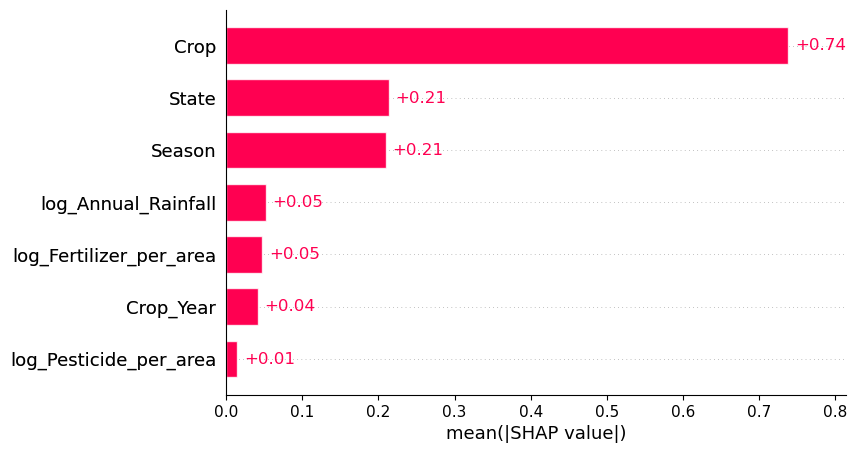

In [177]:
plt.figure(figsize=(12, 8))
shap.plots.bar(shap_values)

17232
Crop                         Sunflower
Crop_Year                         2020
Season                          Summer
State                      Uttarakhand
log_Fertilizer_per_area       5.265846
log_Pesticide_per_area        -0.99425
log_Annual_Rainfall           7.180791
Name: 17344, dtype: object


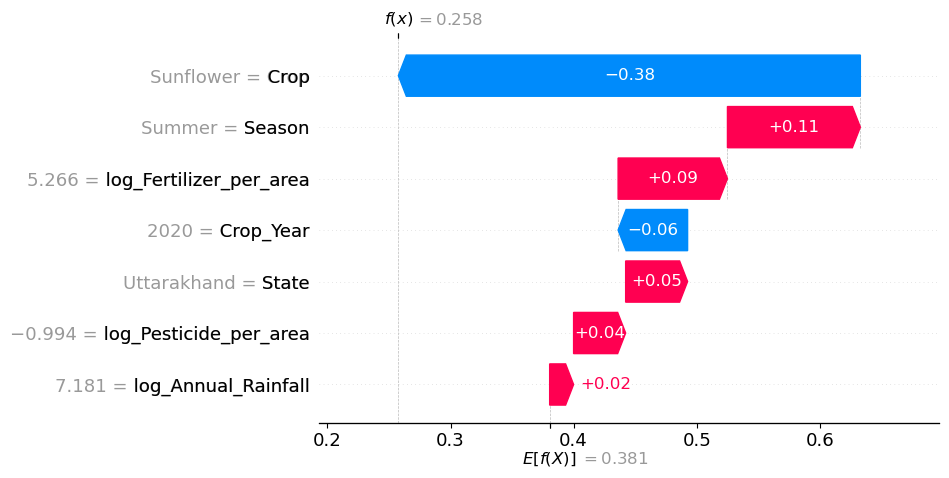

In [178]:
random_idx = np.random.randint(0, X.shape[0])

print(random_idx)
print(X.iloc[random_idx])

shap.plots.waterfall(shap_values[random_idx])
